## Libraries

In [130]:
# !pip install -r "requirements.txt"

In [13]:
import stumpy

import plotly.graph_objs as go

import yfinance as yf

import pandas as pd
import numpy as np

import datetime  

import matplotlib.pyplot as plt

import seaborn as sns

import tqdm
from tqdm import tqdm
import tslearn

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


import tsfresh
from tsfresh import extract_features, extract_relevant_features, select_features, feature_extraction
from tsfresh.feature_extraction import settings

from sklearn.feature_selection import VarianceThreshold

In [14]:
import stocks

In [15]:
from stocks import * 

## Crypto Analysis

Top cryptos by market cap were selected [09/07/2022]
source: [yahoo-finance watchlist](https://finance.yahoo.com/u/yahoo-finance/watchlists/crypto-top-market-cap/)

In [16]:
html_df = pd.read_html('/content/stocks_data.html')[1]

In [17]:
cryptos = list(html_df['Symbol'])

## DataFrame with closing prices of cryptos

In [20]:
start = datetime.datetime(2021, 1, 10)
end = datetime.datetime(2022, 7, 8)

assets = pd.DataFrame()
for i in cryptos:
  assets[i] = yf.download(i, start=start, end=end)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [21]:
assets.tail()

,BTC-USD,ETH-USD,USDT-USD,USDC-USD,BNB-USD,BUSD-USD,XRP-USD,ADA-USD,SOL-USD,DOGE-USD,...,UNI1-USD,YOUC-USD,STETH-USD,FTT-USD,LTC-USD,CRO-USD,LINK-USD,XLM-USD,NEAR-USD,ATOM-USD
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-04,20231.261719,1151.059082,0.999109,1.000306,231.574127,1.000192,0.328790,0.469644,36.785030,0.069472,...,5.297554,0.510532,1117.432861,25.922417,52.243816,0.118540,6.431877,0.111184,3.533401,8.764914
2022-07-05,20190.115234,1134.541016,0.999092,1.000053,230.846359,1.000336,0.325423,0.457632,35.395554,0.067155,...,5.309924,0.510524,1099.648071,25.191893,49.830593,0.116131,6.321958,0.108071,3.398874,8.974499
2022-07-06,20548.246094,1186.973999,0.999098,0.999879,238.499939,1.000704,0.332272,0.462179,37.073563,0.068583,...,5.354458,0.510527,1154.847534,26.265272,50.361088,0.119578,6.338929,0.109371,3.500298,8.908925
2022-07-07,21637.587891,1237.593384,0.999446,1.000092,241.544510,1.000794,0.342151,0.477812,38.518307,0.070621,...,5.737151,0.510739,1206.625610,27.459190,52.142895,0.123488,6.641354,0.113955,3.711768,9.373816
2022-07-08,21731.117188,1222.506226,0.999418,0.999778,240.750717,0.999748,0.341628,0.467311,38.286720,0.069257,...,5.808081,0.510725,1187.248169,27.465851,51.564953,0.122918,6.379156,0.113324,3.598515,9.032530


## Examples

**Crypto_info() function** 

In [22]:
crypto_info('ETH-USD').tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,4733.362793,4859.502930,4485.093262,4636.174316,4636.174316,22748160545
2021-11-11,4635.453613,4778.059082,4580.990234,4730.384277,4730.384277,17933201129
2021-11-12,4724.306641,4808.738770,4510.920410,4667.115234,4667.115234,18316060208
2021-11-13,4666.719238,4702.115234,4582.180664,4651.460449,4651.460449,14457436261
2021-11-14,4648.632812,4689.842773,4516.935547,4626.358887,4626.358887,12172962219


**Candlestick_month() function**

In [23]:
eth = pd.DataFrame(crypto_info('ETH-USD')['Close'])

[*********************100%***********************]  1 of 1 completed


In [24]:
eth.head()

,Close
Date,
2021-01-01,730.367554
2021-01-02,774.534973
2021-01-03,975.507690
2021-01-04,1040.233032
2021-01-05,1100.006104


Percentage change between the current and a prior prices.

In [25]:
eth['return'] = eth.Close.pct_change()

In [26]:
eth.head()

,Close,return
Date,,
2021-01-01,730.367554,NaN
2021-01-02,774.534973,0.060473
2021-01-03,975.507690,0.259475
2021-01-04,1040.233032,0.066350
2021-01-05,1100.006104,0.057461


In [27]:
Candlestick_month('ETH-USD', 'Ethereum')

[*********************100%***********************]  1 of 1 completed


**Candlestick() function**

In [28]:
Candlestick('ETH-USD', 'Ethereum')

[*********************100%***********************]  1 of 1 completed


## Clusterization

1. Cluserization using Kmeans without generated features
2. Cluserization using Kmeans with generated features





### 1. Cluserization using Kmeans without generated features

Create new dataframe assets_norm with normalized assets

In [29]:
assets.fillna(0, inplace=True)

In [30]:
scaled_data = StandardScaler().fit_transform(assets).T

Defining the number of clusters

*   Analysis of SSE and silhoette
*   Defining the number of clusters



The higher silhouette - the better <br>
The lower SSE - the better

100%|██████████| 9/9 [00:00<00:00, 37.91it/s]


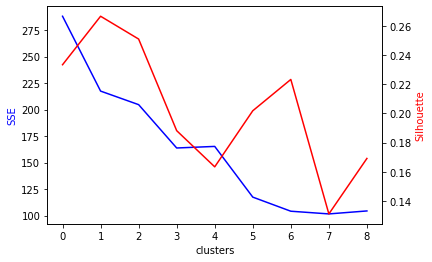

In [44]:
sse = []
silhouette = []
K = range(2, 11)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric='euclidean', init='random', max_iter=300)
    kmeanModel.fit(scaled_data)
    sse.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(scaled_data, kmeanModel.labels_, metric='euclidean'))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(sse, 'b-')
ax2.plot(silhouette, 'r-')

ax1.set_xlabel('clusters')
ax1.set_ylabel('SSE', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

Number of clusters chosen: 6

In [46]:
n_clusters = 6
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric='euclidean', init='random', max_iter=300)
ts_kmeans.fit(scaled_data) #predicting cluster of the assets given 

TimeSeriesKMeans(init='random', max_iter=300, n_clusters=6)

Visualization of cluster centroids

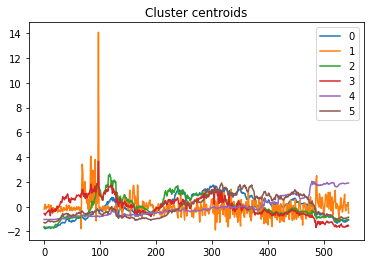

In [47]:
for cluster in range(n_clusters):
  plt.plot(ts_kmeans.cluster_centers_[cluster, :, 0], label=cluster)
plt.title('Cluster centroids')
plt.legend()
plt.show()

Addition of a column **clusters** to the dataframe assets_transposed

In [48]:
assets_transposed = assets.T

In [49]:
assets_transposed['clusters'] = ts_kmeans.predict(scaled_data)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning:

2-Dimensional data passed. Assuming these are 30 1-dimensional timeseries



Cryptos' visualization in the particular cluster

There are 5 in 5 cluster


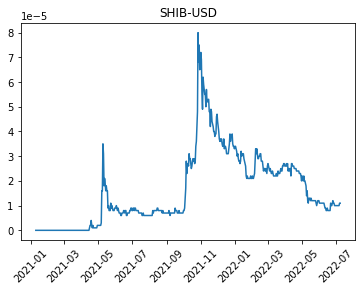

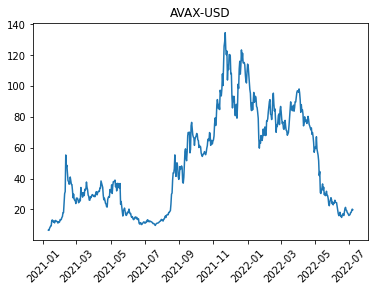

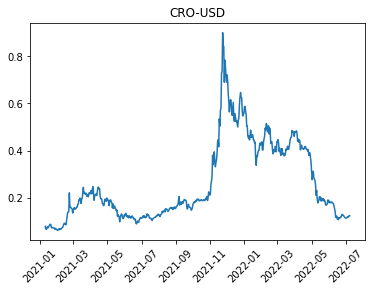

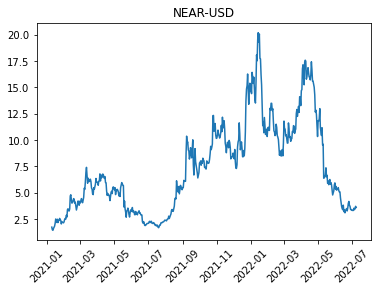

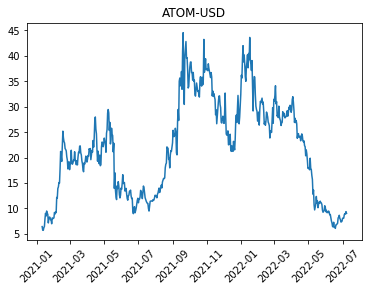

In [54]:
visualize_cluster(5, assets_transposed)

### 2. Cluserization using Kmeans with generated features

Normalization of assets <br> $z=\frac{(x_i - \overline {x})} {σ}$


In [101]:
norm_assets = assets.copy()
norm_assets.fillna(norm_assets.mean(), inplace=True)

In [102]:
for column_ in norm_assets.columns:
  for i in range(norm_assets.shape[0]):
      norm_assets[column_][i] = (norm_assets[column_][i] - np.nanmean(norm_assets[column_])) / np.std(norm_assets[column_])

In [103]:
norm_assets_tr = norm_assets.T.copy()

In [104]:
norm_assets_tr['crypto'] = norm_assets_tr.index

In [105]:
assets_tr = assets.T.copy()

Addition of relevant parameters

In [106]:
settings_efficient = settings.TimeBasedFCParameters()
settings_efficient.update(settings.MinimalFCParameters())
settings_efficient.update(settings.IndexBasedFCParameters())

Feature generation 

In [107]:
EXTRACT = True

if EXTRACT:
    x_norm = extract_features(norm_assets_tr, settings_efficient, column_id='crypto')
    x_norm.to_csv('X_train_tsfel_norm.csv')
else:
    x_norm = pd.read_csv('X_train_tsfel_norm.csv', index_col=0)

x_norm.shape

Feature Extraction: 100%|██████████| 16350/16350 [00:23<00:00, 702.69it/s]


(30, 7085)

7085 features were generated <br>

Tasks:
*   Drop NaN  
*   Drop duplicate columns 
*   Drop columns with the opposite sign




*   Drop NaN




In [113]:
x_norm.dropna(inplace=True, axis=1)

In [114]:
x_norm.shape

(30, 5995)

*   Drop duplicates: their corr = +1 
*   Drop columns with the opposite sign: their corr = -1 



In [115]:
x_red = x_norm.T.drop_duplicates(ignore_index=True).T

In [116]:
x_red_pos = x_red[(x_red > 0)].dropna(axis=1)

In [117]:
x_red_pos.shape

(30, 546)

There are 546 generated features without duplicates and NaN

Features with a variance lower than the threshold are removed

In [118]:
selector = VarianceThreshold()
X_reduced_pos = selector.fit_transform(x_red_pos)

545 features left

In [119]:
X_reduced_pos.shape

(30, 545)

*   Analysis of SSE and silhoette
*   Definition of the number of clusters


100%|██████████| 9/9 [00:00<00:00, 45.41it/s]


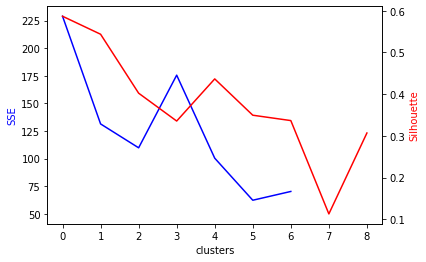

In [121]:
sse = []
silhouette = []
K = range(2, 11)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric='euclidean', init='random', max_iter=300)
    kmeanModel.fit(X_reduced_pos)
    sse.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(X_reduced_pos, kmeanModel.labels_, metric='euclidean'))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(sse, 'b-')
ax2.plot(silhouette, 'r-')

ax1.set_xlabel('clusters')
ax1.set_ylabel('SSE', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()


Number of clusters = 5

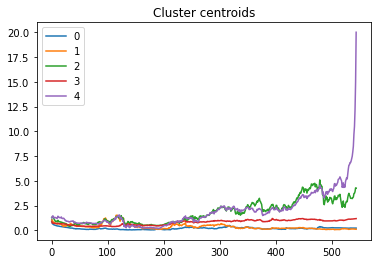

In [122]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric='euclidean', init='random', max_iter=300)
ts_kmeans.fit(X_reduced_pos) #predicting cluster of the assets given 

for cluster in range(n_clusters):
  plt.plot(ts_kmeans.cluster_centers_[cluster, :, 0], label=cluster)
plt.title('Cluster centroids')
plt.legend()
plt.show()

Addition of a column **crypto** with predicted classes to **assets_features_pos** dataframe

In [127]:
x_red_pos['clusters'] = ts_kmeans.predict(X_reduced_pos)
assets_features_pos = assets_tr.join(x_red_pos[['clusters']])

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning:

2-Dimensional data passed. Assuming these are 30 1-dimensional timeseries



Visualization of the clusterization with generated features

There are 3 in 1 cluster


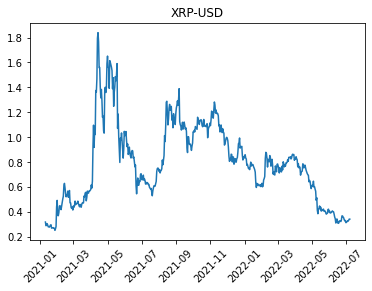

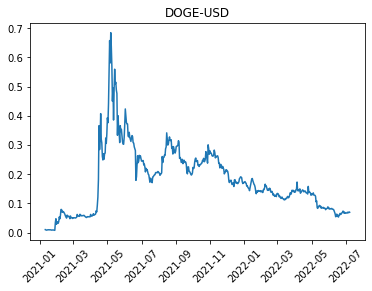

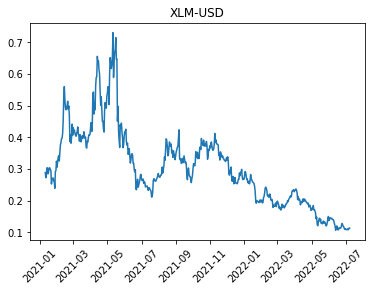

In [129]:
visualize_cluster(1, assets_features_pos)